In [2]:
using Pkg

# Activate local project environment
Pkg.activate(expanduser("/Users/tsohail/Library/CloudStorage/OneDrive-TheUniversityofMelbourne/uom/ocean-ensembles/experiments/"))

# Add the global environment to the package search path
push!(LOAD_PATH, expanduser("/Users/tsohail/.julia/environments/v1.10/"))

# Pkg.precompile()

using CairoMakie, IJulia, JLD2  # From global
using Oceananigans  # From local
using Statistics

  Activating project at `~/Library/CloudStorage/OneDrive-TheUniversityofMelbourne/uom/ocean-ensembles/experiments`


In [3]:
experiment_path = expanduser("/Users/tsohail/Library/CloudStorage/OneDrive-TheUniversityofMelbourne/uom/ocean-ensembles/experiments/")

"/Users/tsohail/Library/CloudStorage/OneDrive-TheUniversityofMelbourne/uom/ocean-ensembles/experiments/"

In [4]:
variables_basins = ["_global", "_atlantic", "_pacific"]
variables_tracers = ["T", "S", "u", "v", "w", "dV"]

variables = [tracer * basin for tracer in variables_tracers, basin in variables_basins]
variables = vec(variables) 

println(variables)

function create_dict(vars, path)
    dicts = Dict()
    for var in vars
        @info var
        try
            # Surface
            dicts[var] = FieldTimeSeries(path, var)
        catch e
            if e isa KeyError
                @warn "Skipping variable $var: Key not found in file."
            else
                rethrow(e)
            end
        end
    end
    return dicts
end

@info "I am loading the integrated fields" 
int_za = create_dict(variables, experiment_path * "zonally_integrated_data.jld2")

@info "I am loading the surface fields" 
surface_props = create_dict(variables_tracers, experiment_path * "global_surface_fields.jld2")

┌ Info: I am loading the integrated fields
└ @ Main /Users/tsohail/Library/CloudStorage/OneDrive-TheUniversityofMelbourne/uom/ocean-ensembles/notebooks/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W2sZmlsZQ==.jl:27
┌ Info: T_global
└ @ Main /Users/tsohail/Library/CloudStorage/OneDrive-TheUniversityofMelbourne/uom/ocean-ensembles/notebooks/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W2sZmlsZQ==.jl:12
┌ Info: S_global
└ @ Main /Users/tsohail/Library/CloudStorage/OneDrive-TheUniversityofMelbourne/uom/ocean-ensembles/notebooks/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W2sZmlsZQ==.jl:12
┌ Info: u_global
└ @ Main /Users/tsohail/Library/CloudStorage/OneDrive-TheUniversityofMelbourne/uom/ocean-ensembles/notebooks/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W2sZmlsZQ==.jl:12
┌ Info: v_global
└ @ Main /Users/tsohail/Library/CloudStorage/OneDrive-TheUniversityofMelbourne/uom/ocean-ensembles/notebooks/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W2sZmlsZQ==.jl:12
┌ In

Dict{Any, Any} with 5 entries:
  "v" => 360×180×1×2201 FieldTimeSeries{InMemory} located at (Center, Face, Cen…
  "S" => 360×180×1×2201 FieldTimeSeries{InMemory} located at (Center, Center, C…
  "w" => 360×180×1×2201 FieldTimeSeries{InMemory} located at (Center, Center, F…
  "T" => 360×180×1×2201 FieldTimeSeries{InMemory} located at (Center, Center, C…
  "u" => 360×180×1×2201 FieldTimeSeries{InMemory} located at (Face, Center, Cen…

## Surface Analysis

(334,)


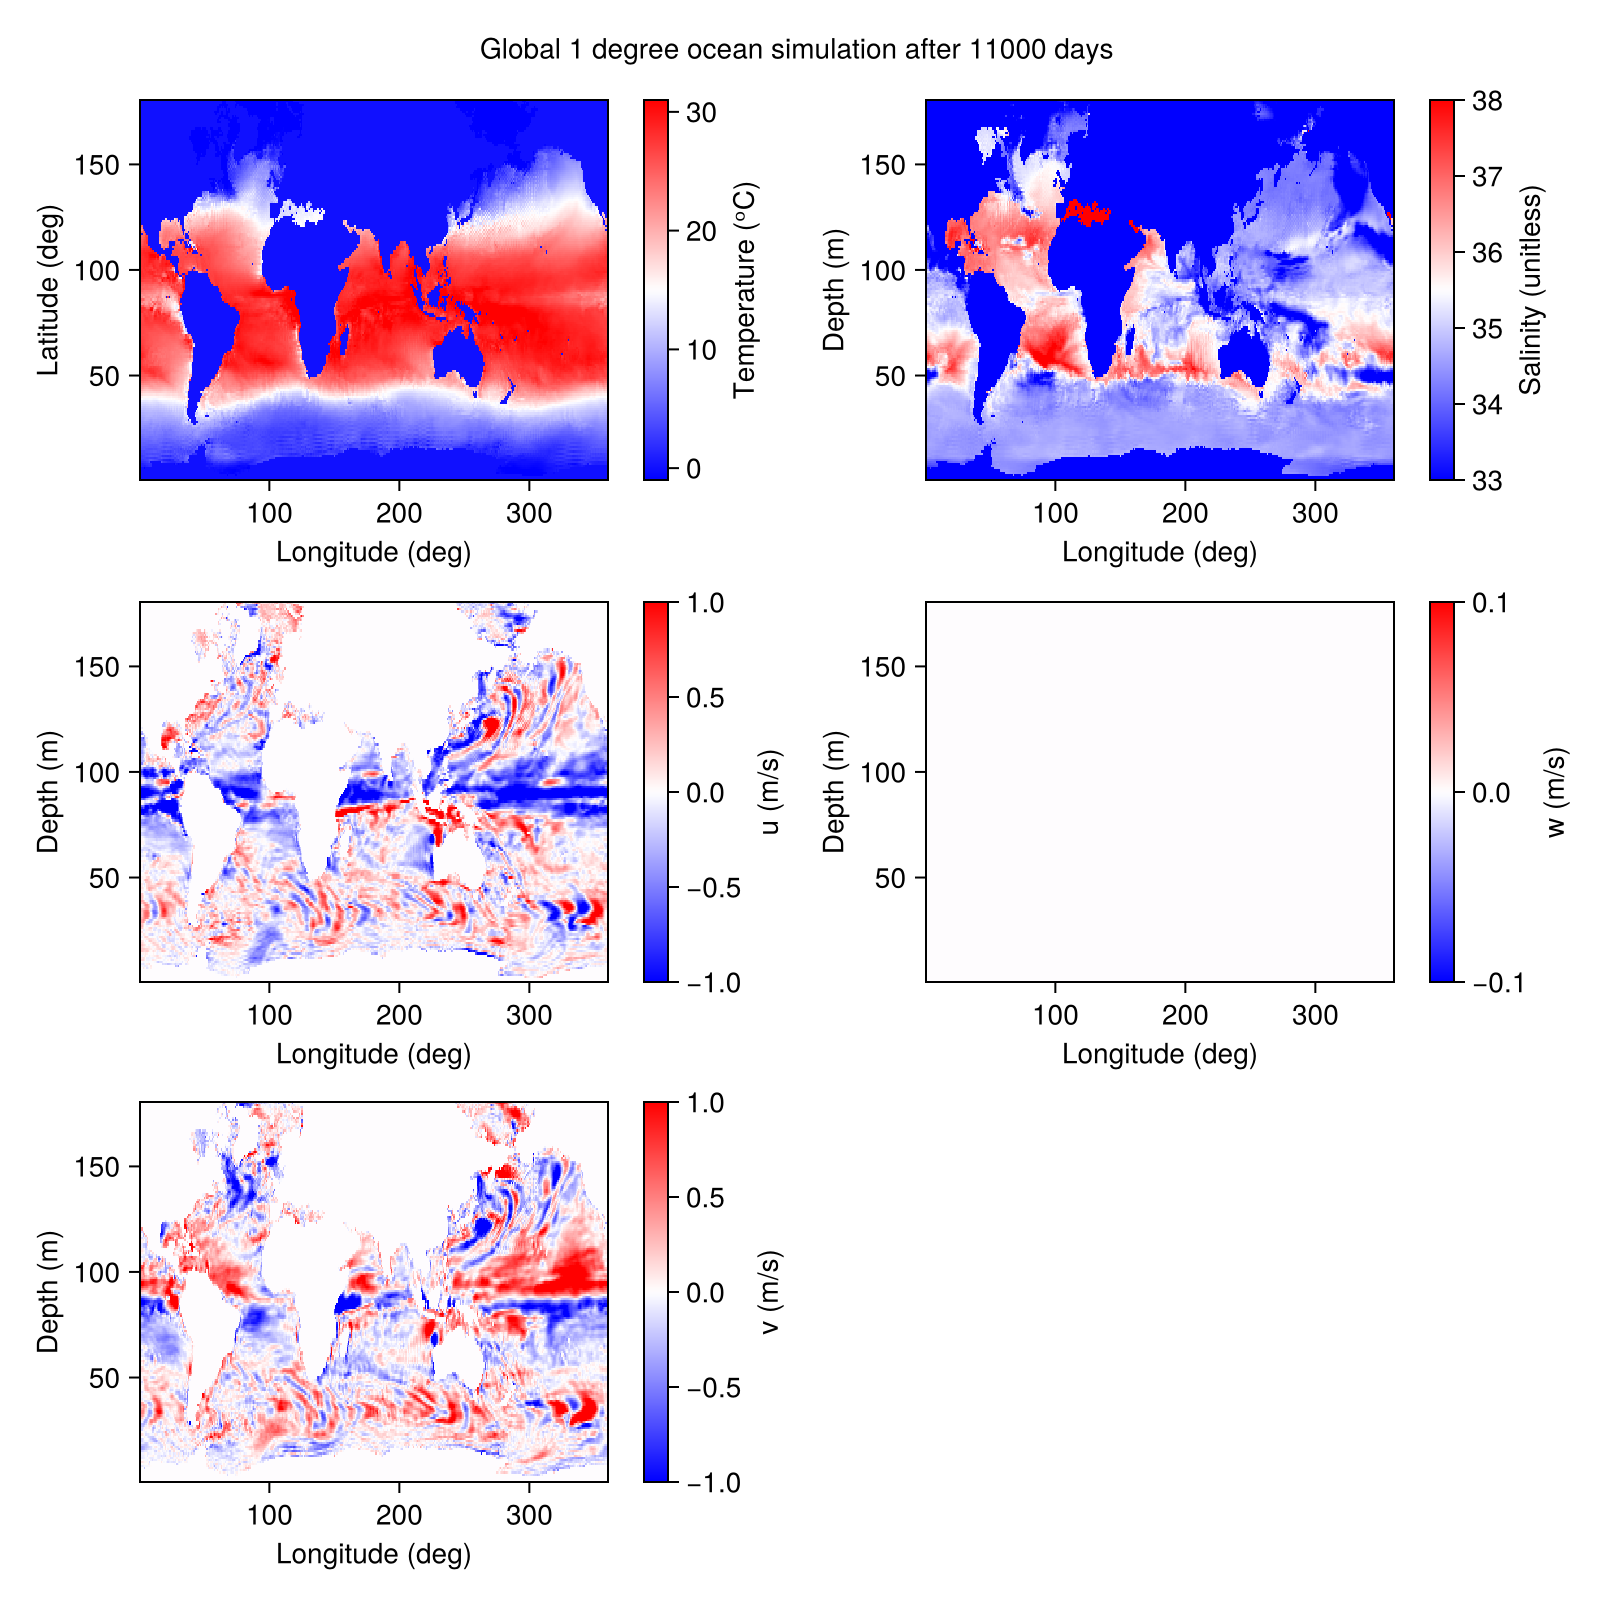

CairoMakie.Screen{IMAGE}


In [11]:
fig = Figure(size = (800, 800))
# axs = Axis(fig[1, 1], xlabel="Longitude (deg)", ylabel="Latitude (deg)")

time_slice = 2201

times = surface_props["T"].times
println(size(times))
title = string("Global 1 degree ocean simulation after ",
                         prettytime(times[time_slice] - times[1]))

axs = Axis(fig[1, 1], xlabel="Longitude (deg)", ylabel="Latitude (deg)")
hm = heatmap!(axs, view(interior(surface_props["T"][time_slice]), :, :, 1), colorrange = (-1,31), colormap = :bwr, nan_color=:lightgray)
Colorbar(fig[1, 2], hm, label = "Temperature (ᵒC)")

axs = Axis(fig[2, 1], xlabel="Longitude (deg)", ylabel="Depth (m)")
hm = heatmap!(axs, view(interior(surface_props["u"][time_slice]), :, :, 1) , colorrange = (-1,1), colormap = :bwr, nan_color=:lightgray)
Colorbar(fig[2, 2], hm, label = "u (m/s)")

axs = Axis(fig[3, 1], xlabel="Longitude (deg)", ylabel="Depth (m)")
hm = heatmap!(axs, view(interior(surface_props["v"][time_slice]), :, :, 1) , colorrange = (-1,1), colormap = :bwr, nan_color=:lightgray)
Colorbar(fig[3, 2], hm, label = "v (m/s)")

axs = Axis(fig[2, 3], xlabel="Longitude (deg)", ylabel="Depth (m)")
hm = heatmap!(axs, view(interior(surface_props["w"][time_slice]), :, :, 1), colorrange = (-.1,.1), colormap = :bwr, nan_color=:lightgray)
Colorbar(fig[2, 4], hm, label = "w (m/s)")

axs = Axis(fig[1, 3], xlabel="Longitude (deg)", ylabel="Depth (m)")
hm = heatmap!(axs, view(interior(surface_props["S"][time_slice]), :, :, 1) , colorrange = (33, 38), colormap = :bwr, nan_color=:lightgray)
Colorbar(fig[1, 4], hm, label = "Salinity (unitless)")

Label(fig[0, :], title)
save("/Users/tsohail/Library/CloudStorage/OneDrive-TheUniversityofMelbourne/uom/ocean-ensembles/figures/surface.png", fig)
display(fig)


## Zonal analysis

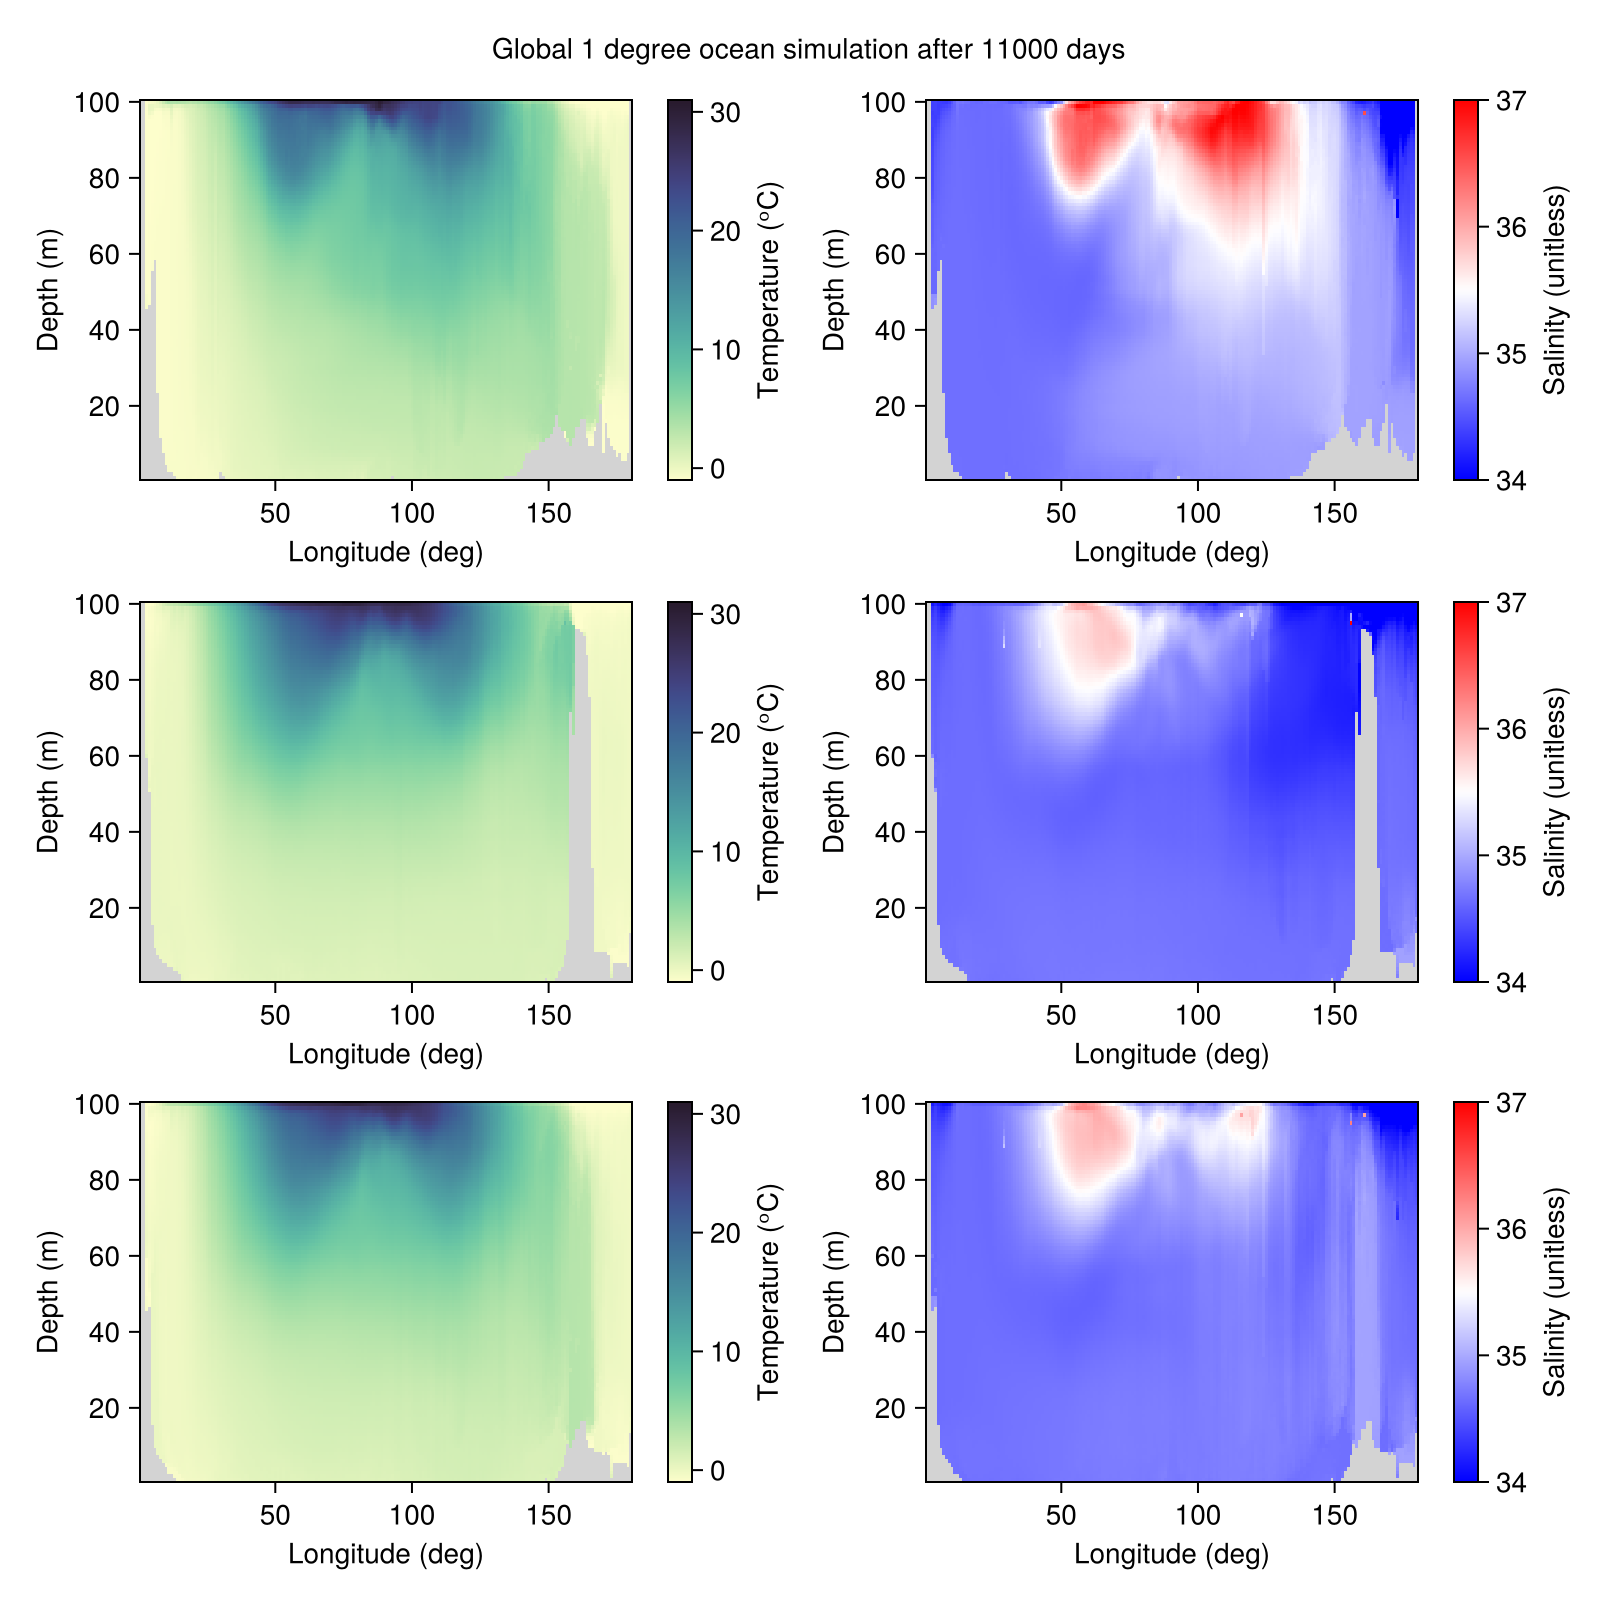

CairoMakie.Screen{IMAGE}


In [10]:
fig = Figure(size = (800, 800))
# axs = Axis(fig[1, 1], xlabel="Longitude (deg)", ylabel="Latitude (deg)")

time_slice = 334

times = int_za["S_atlantic"].times

S_avg_atl = view(interior(int_za["S_atlantic"][time_slice]/int_za["dV_atlantic"][time_slice]), 1, :, :)
S_avg_ipac = view(interior(int_za["S_pacific"][time_slice]/int_za["dV_pacific"][time_slice]), 1, :, :)
S_avg_glob = view(interior(int_za["S_global"][time_slice]/int_za["dV_global"][time_slice]), 1, :, :)
T_avg_atl = view(interior(int_za["T_atlantic"][time_slice]/int_za["dV_atlantic"][time_slice]), 1, :, :)
T_avg_ipac = view(interior(int_za["T_pacific"][time_slice]/int_za["dV_pacific"][time_slice]), 1, :, :)
T_avg_glob = view(interior(int_za["T_global"][time_slice]/int_za["dV_global"][time_slice]), 1, :, :)

title = string("Global 1 degree ocean simulation after ",
                         prettytime(times[time_slice] - times[1]))

axs = Axis(fig[1, 1], xlabel="Longitude (deg)", ylabel="Depth (m)")
hm = heatmap!(axs, T_avg_atl, colorrange = (-1,31), colormap = :deep, nan_color=:lightgray)
Colorbar(fig[1, 2], hm, label = "Temperature (ᵒC)")

axs = Axis(fig[2, 1], xlabel="Longitude (deg)", ylabel="Depth (m)")
hm = heatmap!(axs, T_avg_ipac , colorrange = (-1,31), colormap = :deep, nan_color=:lightgray)
Colorbar(fig[2, 2], hm, label = "Temperature (ᵒC)")

axs = Axis(fig[3, 1], xlabel="Longitude (deg)", ylabel="Depth (m)")
hm = heatmap!(axs, T_avg_glob , colorrange = (-1,31), colormap = :deep, nan_color=:lightgray)
Colorbar(fig[3, 2], hm, label = "Temperature (ᵒC)")

axs = Axis(fig[1, 3], xlabel="Longitude (deg)", ylabel="Depth (m)")
hm = heatmap!(axs, S_avg_atl, colorrange = (34, 37), colormap = :bwr, nan_color=:lightgray)
Colorbar(fig[1, 4], hm, label = "Salinity (unitless)")

axs = Axis(fig[2, 3], xlabel="Longitude (deg)", ylabel="Depth (m)")
hm = heatmap!(axs, S_avg_ipac , colorrange = (34, 37), colormap = :bwr, nan_color=:lightgray)
Colorbar(fig[2, 4], hm, label = "Salinity (unitless)")

axs = Axis(fig[3, 3], xlabel="Longitude (deg)", ylabel="Depth (m)")
hm = heatmap!(axs, S_avg_glob , colorrange = (34, 37), colormap = :bwr, nan_color=:lightgray)
Colorbar(fig[3, 4], hm, label = "Salinity (unitless)")

Label(fig[0, :], title)

save("/Users/tsohail/Library/CloudStorage/OneDrive-TheUniversityofMelbourne/uom/ocean-ensembles/figures/zonal_average.png", fig)
display(fig)

In [ ]:
# Mask NaNs by replacing them with a value that's less than any valid temperature
# argmax(filter(!isnan, surface_props["T"][1]))
# # Find the index of the maximum value
# max_index = argmax(T_clean)  # Get index of max value

# # Retrieve the value of the max temperature
# max_value = T_data[max_index]
[argmax(interior(surface_props["T"][time_step]))[1],argmax(interior(surface_props["T"][time_step]))[2]]

72

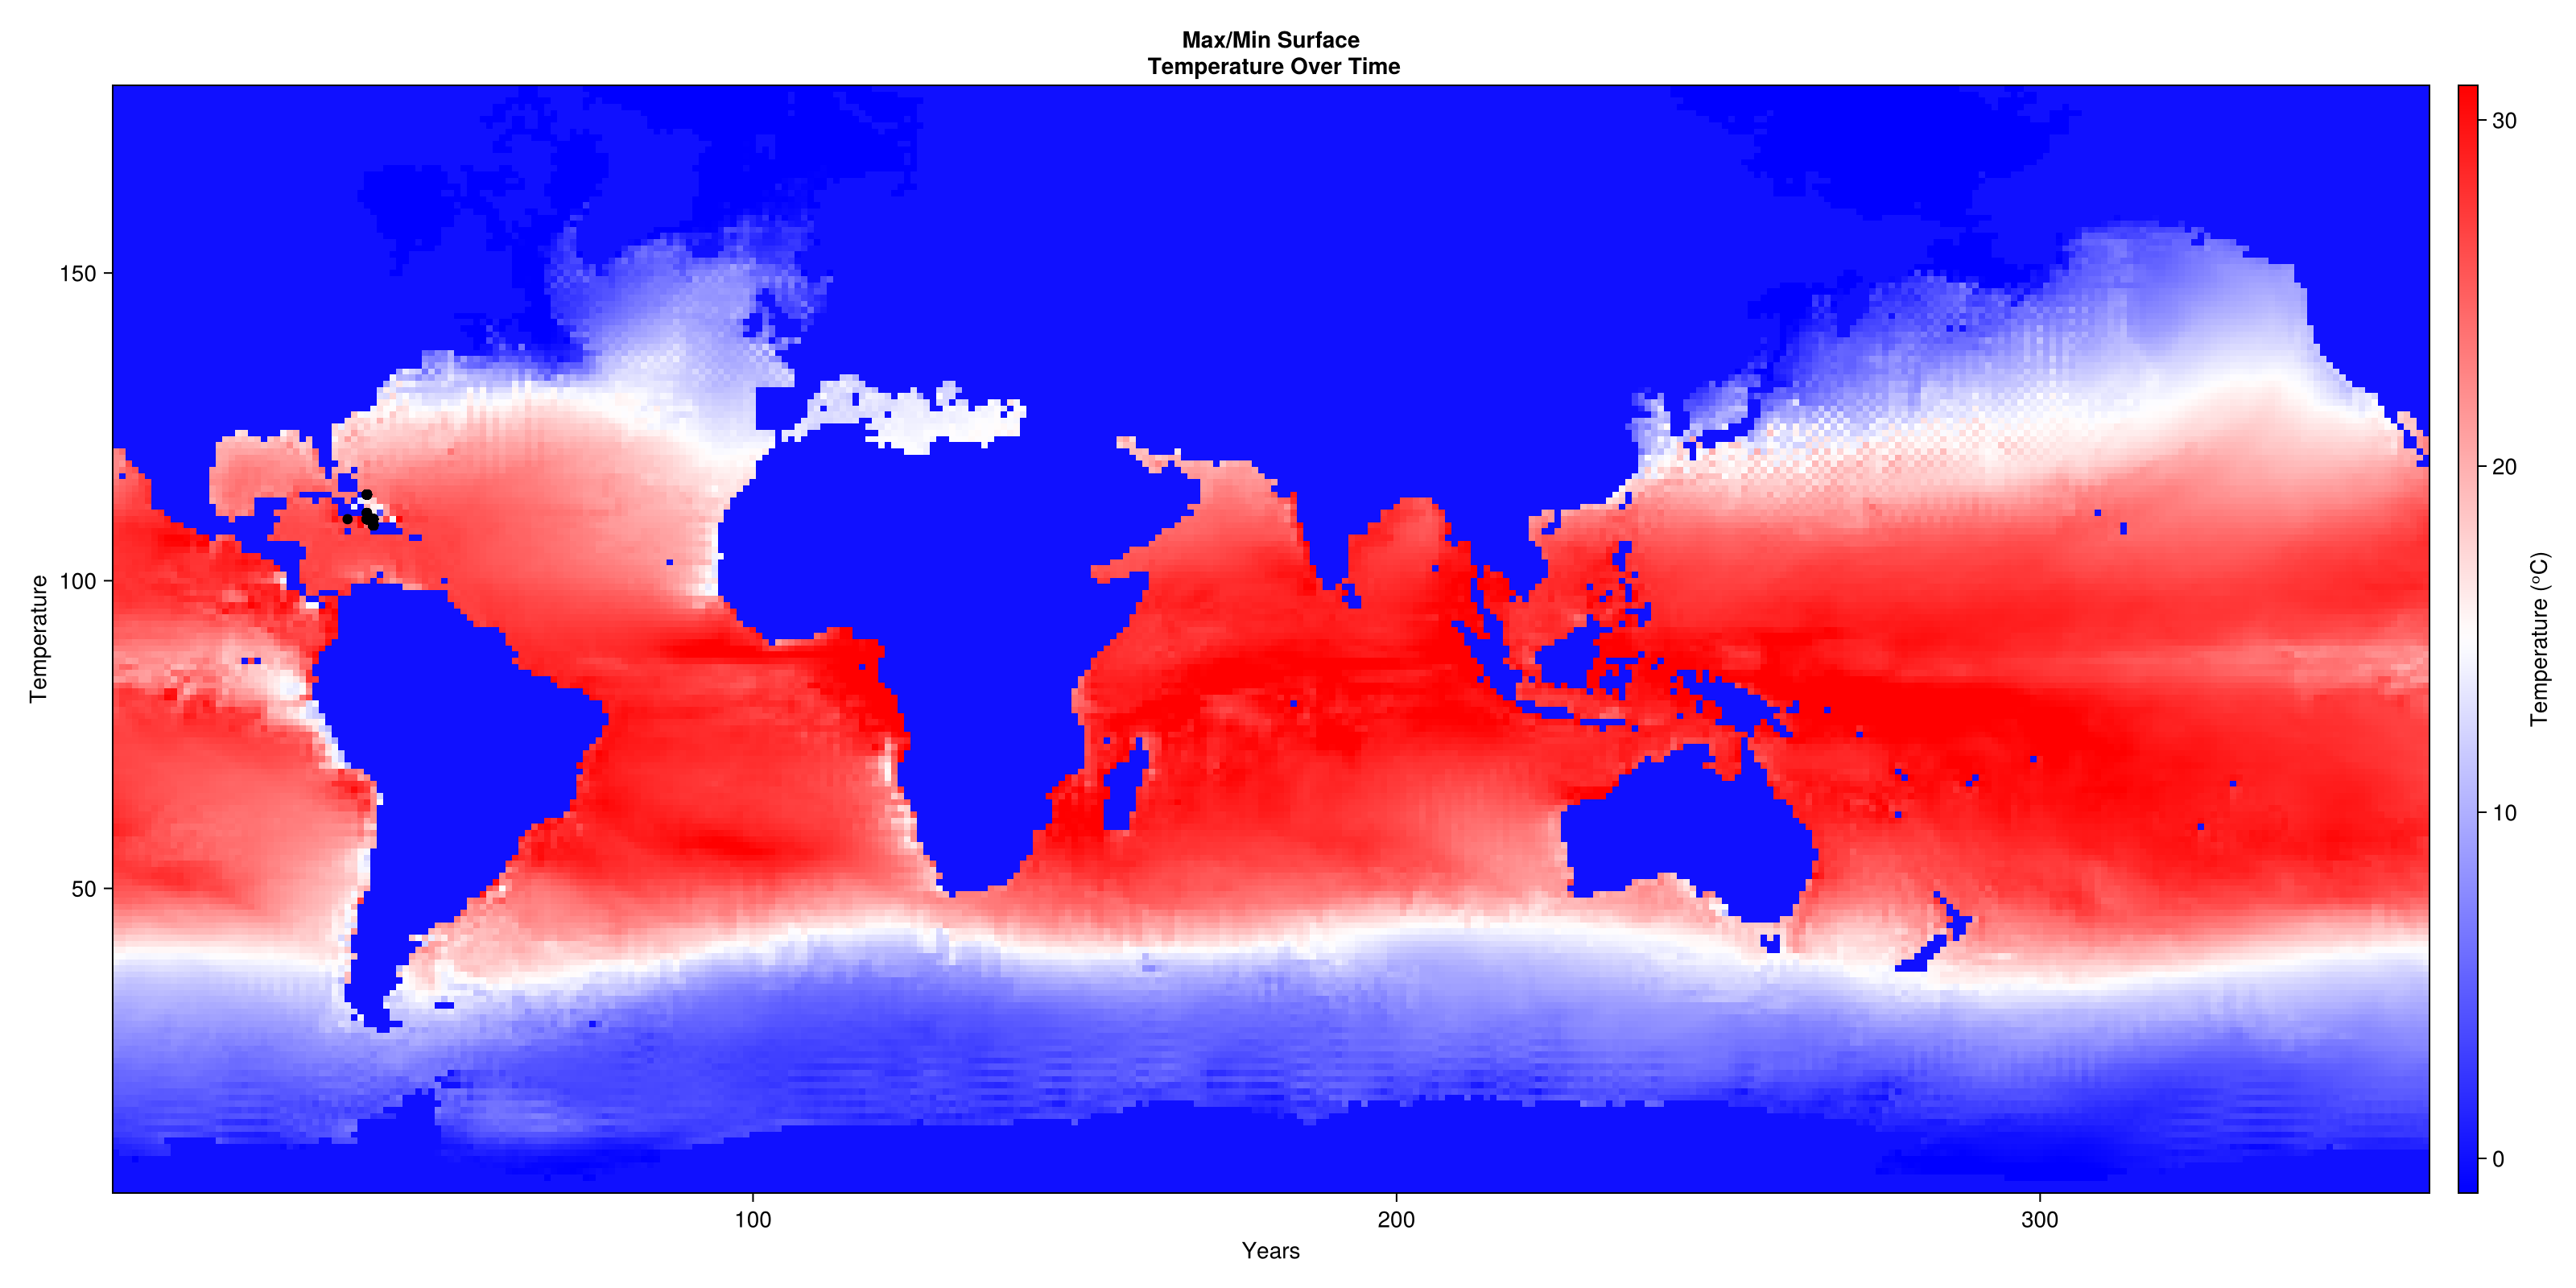

CairoMakie.Screen{IMAGE}


In [72]:
maxes

2201-element Vector{Any}:
 31.250783920288086
 31.870275497436523
 33.36981201171875
 35.1780891418457
 35.968841552734375
 36.94234848022461
 38.184932708740234
 38.07843017578125
 38.148616790771484
 38.16925048828125
  ⋮
 37.47492599487305
 45.196998596191406
 38.98893356323242
 43.1923942565918
 39.08038330078125
 42.23177719116211
 39.25348663330078
 37.04600143432617
 36.815311431884766

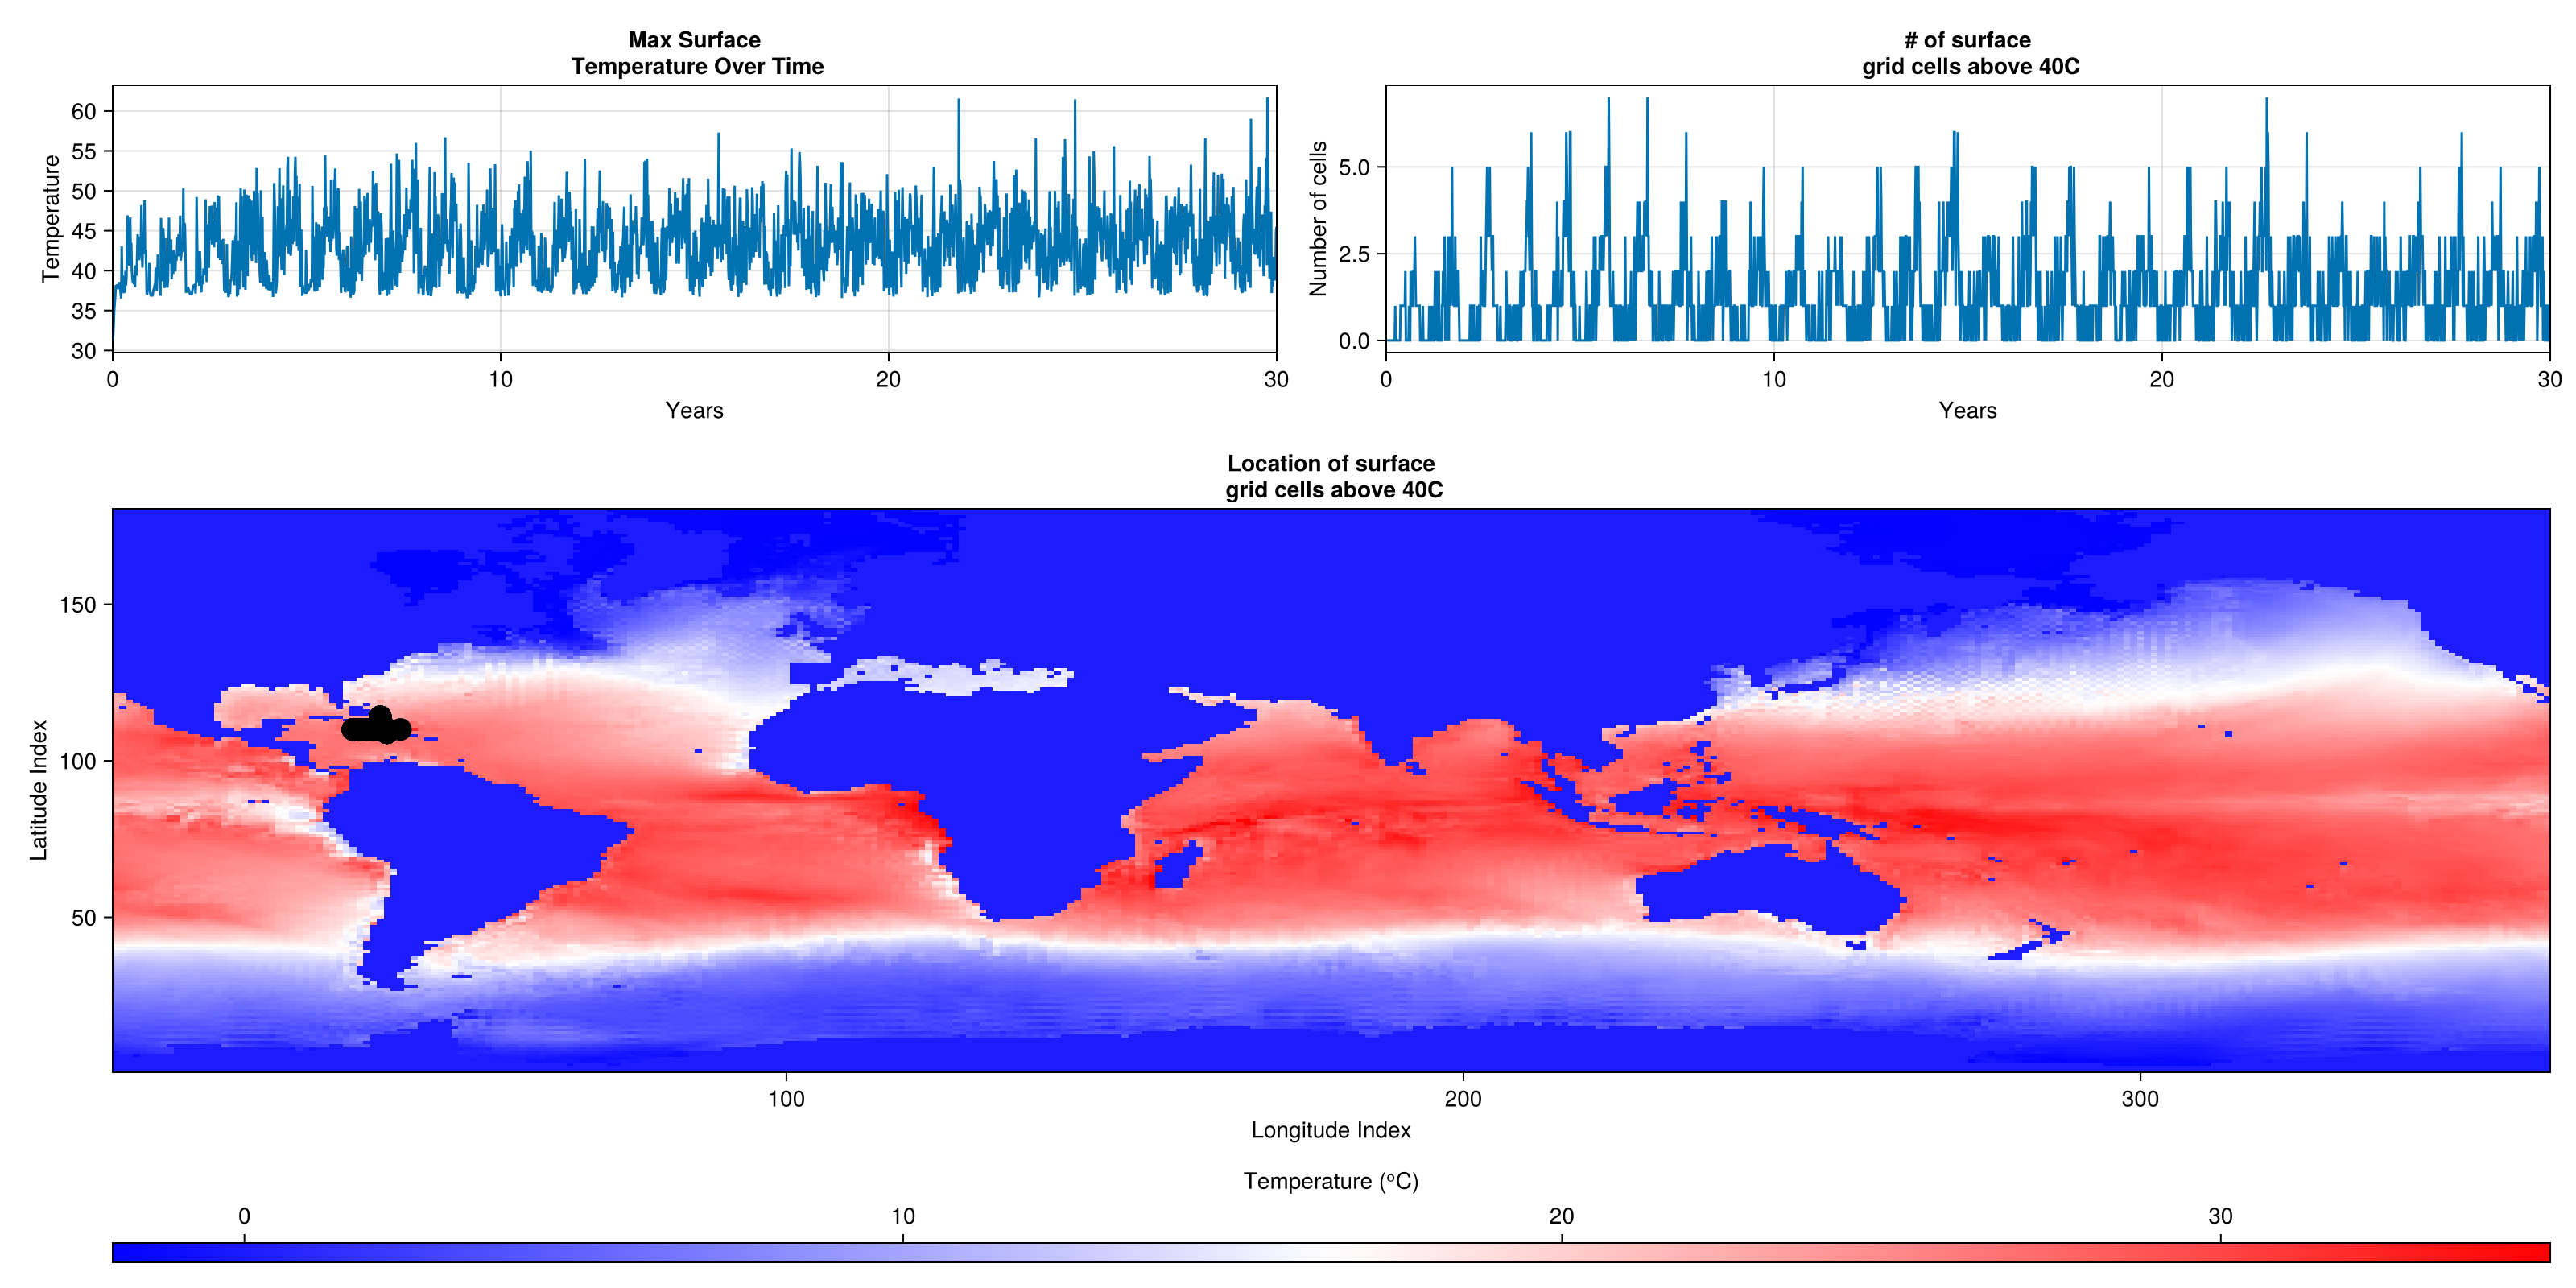

CairoMakie.Screen{IMAGE}


In [103]:
temp_too_high = 40

mxtemp = zeros(length(times))  # Ensure the array is 1D with the correct size
mntemp = zeros(length(times))  # Ensure the array is 1D with the correct size
x_indices = []
y_indices = []
hightmp_counter = zeros(length(times))
for time_step in eachindex(times)  # Proper way to iterate over indices
    mxtemp[time_step] = maximum(filter(!isnan, surface_props["T"][time_step]))  # Ignore NaNs
    mntemp[time_step] = minimum(filter(!isnan, surface_props["T"][time_step]))  # Ignore NaNs
    T_array = interior(surface_props["T"][time_step])
    hightmp_counter[time_step] = count(T_array .> temp_too_high)
    # Extract the interior data
    interior_data = interior(surface_props["T"][time_step])

    # Find the (i, j) index of the maximum temperature in the interior
    max_index = argmax(interior_data)

    if mxtemp[time_step] >=temp_too_high
        push!(x_indices, max_index[1])
        push!(y_indices, max_index[2])
    end
    
end


fig = Figure(size = (1600, 800))
ax1 = Axis(fig[1, 1], xlabel="Years", ylabel="Temperature", title="Max Surface\n Temperature Over Time")
ax2 = Axis(fig[1,2], xlabel="Years", ylabel="Number of cells", title="# of surface\n grid cells above 40C")
ax3 = Axis(fig[2:3,:], xlabel="Longitude Index", ylabel="Latitude Index", title="Location of surface\n grid cells above 40C")

lines!(ax1, times/(3600*24*365.25), mxtemp)
# lines!(ax1, times/(3600*24*365.25), mntemp)
lines!(ax2, times/(3600*24*365.25), (hightmp_counter))
hm = heatmap!(ax3, view(interior(surface_props["T"][2201]), :, :, 1), colorrange = (-2,35), colormap = :bwr, nan_color=:lightgray)
Colorbar(fig[4, :], hm, label = "Temperature (ᵒC)", vertical = false)

scatter!(ax3, x_indices, y_indices, color=:black, markersize=20)

xlims!(ax2, 0,30)
xlims!(ax1, 0,30)

save("/Users/tsohail/Library/CloudStorage/OneDrive-TheUniversityofMelbourne/uom/ocean-ensembles/figures/minmax_diff.png", fig)

display(fig)

In [93]:
30/1.4583333333333333

20.571428571428573

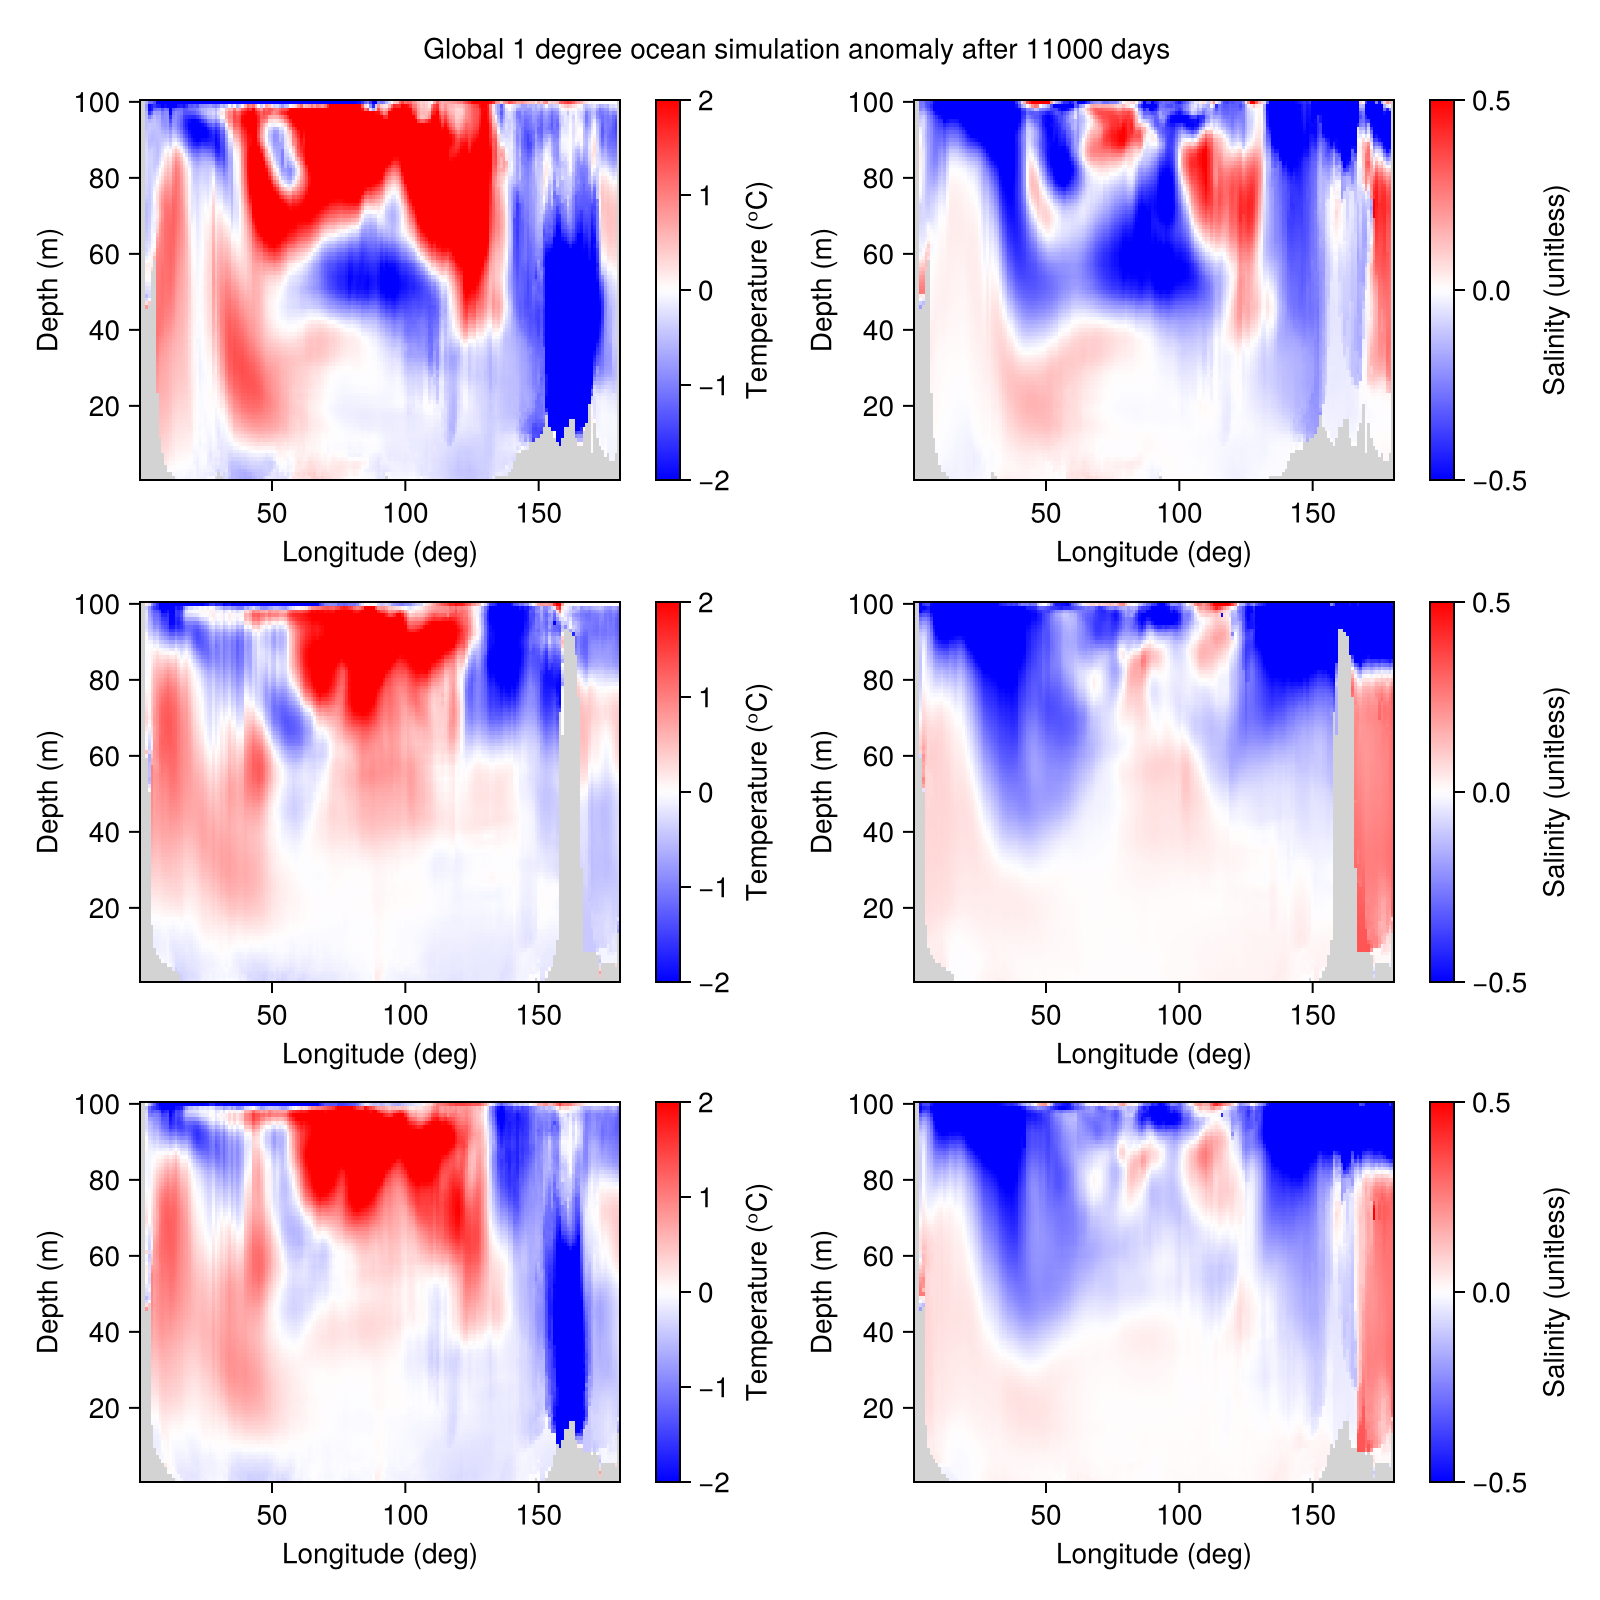

CairoMakie.Screen{IMAGE}


In [13]:
fig = Figure(size = (800, 800))
# axs = Axis(fig[1, 1], xlabel="Longitude (deg)", ylabel="Latitude (deg)")

time_slice = 1

times = int_za["S_atlantic"].times

S_avg_atl_init = view(interior(int_za["S_atlantic"][time_slice]/int_za["dV_atlantic"][time_slice]), 1, :, :)
S_avg_ipac_init = view(interior(int_za["S_pacific"][time_slice]/int_za["dV_pacific"][time_slice]), 1, :, :)
S_avg_glob_init = view(interior(int_za["S_global"][time_slice]/int_za["dV_global"][time_slice]), 1, :, :)
T_avg_atl_init = view(interior(int_za["T_atlantic"][time_slice]/int_za["dV_atlantic"][time_slice]), 1, :, :)
T_avg_ipac_init = view(interior(int_za["T_pacific"][time_slice]/int_za["dV_pacific"][time_slice]), 1, :, :)
T_avg_glob_init = view(interior(int_za["T_global"][time_slice]/int_za["dV_global"][time_slice]), 1, :, :)

time_slice = 334

S_avg_atl = view(interior(int_za["S_atlantic"][time_slice]/int_za["dV_atlantic"][time_slice]), 1, :, :)
S_avg_ipac = view(interior(int_za["S_pacific"][time_slice]/int_za["dV_pacific"][time_slice]), 1, :, :)
S_avg_glob = view(interior(int_za["S_global"][time_slice]/int_za["dV_global"][time_slice]), 1, :, :)
T_avg_atl = view(interior(int_za["T_atlantic"][time_slice]/int_za["dV_atlantic"][time_slice]), 1, :, :)
T_avg_ipac = view(interior(int_za["T_pacific"][time_slice]/int_za["dV_pacific"][time_slice]), 1, :, :)
T_avg_glob = view(interior(int_za["T_global"][time_slice]/int_za["dV_global"][time_slice]), 1, :, :)


axs = Axis(fig[1, 1], xlabel="Longitude (deg)", ylabel="Depth (m)")
hm = heatmap!(axs, T_avg_atl - T_avg_atl_init, colorrange = (-2,2), colormap = :bwr, nan_color=:lightgray)
Colorbar(fig[1, 2], hm, label = "Temperature (ᵒC)")

axs = Axis(fig[2, 1], xlabel="Longitude (deg)", ylabel="Depth (m)")
hm = heatmap!(axs, T_avg_ipac - T_avg_ipac_init, colorrange = (-2,2), colormap = :bwr, nan_color=:lightgray)
Colorbar(fig[2, 2], hm, label = "Temperature (ᵒC)")

axs = Axis(fig[3, 1], xlabel="Longitude (deg)", ylabel="Depth (m)")
hm = heatmap!(axs, T_avg_glob - T_avg_glob_init, colorrange = (-2,2), colormap = :bwr, nan_color=:lightgray)
Colorbar(fig[3, 2], hm, label = "Temperature (ᵒC)")

axs = Axis(fig[1, 3], xlabel="Longitude (deg)", ylabel="Depth (m)")
hm = heatmap!(axs, S_avg_atl - S_avg_atl_init, colorrange = (-0.5, 0.5), colormap = :bwr, nan_color=:lightgray)
Colorbar(fig[1, 4], hm, label = "Salinity (unitless)")

axs = Axis(fig[2, 3], xlabel="Longitude (deg)", ylabel="Depth (m)")
hm = heatmap!(axs, S_avg_ipac - S_avg_ipac_init, colorrange = (-0.5, 0.5), colormap = :bwr, nan_color=:lightgray)
Colorbar(fig[2, 4], hm, label = "Salinity (unitless)")

axs = Axis(fig[3, 3], xlabel="Longitude (deg)", ylabel="Depth (m)")
hm = heatmap!(axs, S_avg_glob - S_avg_glob_init, colorrange = (-0.5, 0.5), colormap = :bwr, nan_color=:lightgray)
Colorbar(fig[3, 4], hm, label = "Salinity (unitless)")

Label(fig[0, :], title)
save("/Users/tsohail/Library/CloudStorage/OneDrive-TheUniversityofMelbourne/uom/ocean-ensembles/figures/zonal_anomaly.png", fig)

display(fig)

## Global

In [8]:
grid = RectilinearGrid(size=(4, 5, 6), extent=(2, 3, 4))
c = CenterField(grid)
Integral(Field(Integral(c, dims=(2, 3))), dims=(1))

Integral of BinaryOperation at (Center, ⋅, ⋅) over dims (1,)
└── operand: BinaryOperation at (Center, ⋅, ⋅)
    └── grid: 4×5×6 RectilinearGrid{Float64, Periodic, Periodic, Bounded} on CPU with 3×3×3 halo

In [9]:
int_za["T_global"][1]

1×180×100 Field{Nothing, Center, Center} reduced over dims = (1,) on ImmersedBoundaryGrid on CPU
├── grid: 360×180×100 ImmersedBoundaryGrid{Float64, Periodic, Oceananigans.Grids.RightConnected, Bounded} on CPU with 5×5×4 halo
├── operand: Integral of ConditionalOperation of BinaryOperation at (Center, Center, Center) with condition (::Oceananigans.ImmersedBoundaries.NotImmersed{typeof(Oceananigans.ImmersedBoundaries.truefunc)}) (generic function with 0 methods) over dims (2, 3)
├── status: time=0.0
└── data: 370×1×1 OffsetArray(::Array{Float64, 3}, -4:365, 1:1, 1:1) with eltype Float64 with indices -4:365×1:1×1:1
    └── max=3.70247e18, min=0.0, mean=1.02846e16

In [11]:
using Oceananigans.Fields: instantiate
using Oceananigans: location
using ClimaOcean


In [ ]:

Nx, Ny, Nz = 60, 30, 20

# grid = Oceananigans.OrthogonalSphericalShellGrids.TripolarGrid(CPU(); size=(Nx, Ny, Nz),
#                                                                           halo=(7, 7, 7),
#                                                                             z=(-1000, 0))

grid = LatitudeLongitudeGrid(CPU();
                             size = (Nx, Ny, Nz),
                             halo = (7, 7, 7),
                             z = (-1000, 0),
                             latitude  = (-75, 75),
                             longitude = (0, 360))

ocean = ocean_simulation(grid)


In [ ]:
using StaticArrays
using PolygonOps
using Oceananigans.Fields: instantiate, location

function basin_mask(grid::Union{TripolarGrid, ImmersedBoundaryGrid{<:Any, <:Any, <:Any, <:Any, <:TripolarGrid}, LatitudeLongitudeGrid}, 
    basin::AbstractString, 
    var::Oceananigans.Field)

    IndLonsPts=[20, 20, 40,100, 100, 110,145,145,20];
    IndLatsPts=[-90, 28, 30, 30, 0, -10,-10,-90,-90];
    
    PacLonsPts=[145, 145, 110,100, 100, 260,260,300,300, 145];
    PacLatsPts=[-90, -10, -10, 0, 90, 90,20,0,-90,-90];
    
    # Atlantic is a bit more complicated
    AtleastLonsPts = [260,260,300,300, 360, 360, 260];
    AtleastLatsPts = [90,20,0,-90,-90, 90,90] ;
    AtlwestLonsPts = [0,20,20,0,0]
    AtlwestLatsPts = [-90,-90,28,30,-90] ;
    AtlarcticLonsPts = [0,20,20,0,0]
    AtlarcticLatsPts = [50,55,90,90,50]

    Indpolygon = SVector.(IndLonsPts, IndLatsPts)    # boundary of the polygon
    Pacpolygon = SVector.(PacLonsPts, PacLatsPts)    # boundary of the polygon
    # Atlantic has multiple polygons due to lon grid bw 0 and 360
    Atleastpolygon = SVector.(AtleastLonsPts, AtleastLatsPts)    # boundary of the polygon
    Atlwestpolygon = SVector.(AtlwestLonsPts, AtlwestLatsPts)    # boundary of the polygon
    Atlarcticpolygon = SVector.(AtlarcticLonsPts, AtlarcticLatsPts)    # boundary of the polygon

    lons = λnodes(grid, instantiate.(location(var))...)
    lats = φnodes(grid, instantiate.(location(var))...)

    if isa(grid, LatitudeLongitudeGrid)
        X,Y = meshgrid(lons[1:Nx], lats[1:Ny])
        points = vec(SVector.(X, Y))
        lons, lats = X,Y
    else
        points = vec(SVector.(lons,lats))
    end
    
    if basin in ["indian", "Indian"]
        polygon = Indpolygon
        mask = transpose(reshape([inpolygon(p, polygon; in=true, on=false, out=false) for p in points], size(lats)))

    elseif basin in ["pacific", "Pacific"]
        polygon = Pacpolygon
        mask = transpose(reshape([inpolygon(p, polygon; in=true, on=false, out=false) for p in points], size(lats)))

    elseif basin in ["atlantic", "Atlantic"]
        polygon = Atleastpolygon
        mask_1 = transpose(reshape([inpolygon(p, polygon; in=true, on=false, out=false) for p in points], size(lats)))
        
        polygon = Atlwestpolygon
        mask_2 = transpose(reshape([inpolygon(p, polygon; in=true, on=false, out=false) for p in points], size(lats)))
        
        polygon = Atlarcticpolygon
        mask_3 = transpose(reshape([inpolygon(p, polygon; in=true, on=false, out=false) for p in points], size(lats)))
    
        mask = mask_1 .+ mask_3 .+ mask_2 
    
    elseif basin in ["indo-pacific", "Indo-pacific", "Indo-Pacific"]
        polygon = Indpolygon
        mask_1 = transpose(reshape([inpolygon(p, polygon; in=true, on=false, out=false) for p in points], size(lats)))
        
        polygon = Pacpolygon
        mask_2 = transpose(reshape([inpolygon(p, polygon; in=true, on=false, out=false) for p in points], size(lats)))
    
        mask = mask_1 .+ mask_2  
    else
        throw("Basin unknown, must be one of Indian, Atlantic, Pacific, or Indo-Pacific")
    end

    is_valid = maximum(mask) == 1
    is_valid || throw(ErrorException("Maximum value of mask is not 1"))    
    bool_mask = convert(Array{Bool}, mask)
    return bool_mask
end

In [ ]:
mask_atl = basin_mask(grid, "Atlantic", ocean.model.velocities[1])

In [ ]:
ocean.model.velocities.u

avg_u = compute!(Average(ocean.model.velocities.u, condition=mask_atl))
display(avg_u)

In [ ]:
fig = heatmap!(lon, lat, mask_Ipac_u)
display(fig)

In [ ]:
println(size(tplats[1:Nx, 1:Ny]))
println(size(tplons[1:Nx, 1:Ny]))
println(size(transpose(mask_Ipac_u)))

In [ ]:
fig = Figure()
ax = Axis(fig[1, 1], xlabel="Longitude", ylabel="Latitude", title="Basin Map")
hm = heatmap!(ax, lon, lat, surface_props["S"][1], colormap=:viridis)
hm = heatmap!(ax, lon, lat, (mask_Ipac_u), colormap=:bwr, alpha = 0.5)

# CairoMakie.lines!(Indpolygon)
# CairoMakie.lines!(Pacpolygon)
# CairoMakie.lines!(Atleastpolygon)
# CairoMakie.lines!(Atlwestpolygon)
# CairoMakie.lines!(Atlarcticpolygon)

Colorbar(fig[1, 2], hm)
display(fig)

In [ ]:
using PolygonOps, StaticArrays

IndLonsPts=[20, 20, 40,100, 100, 110,145,145,20];
IndLatsPts=[-90, 28, 30, 30, 0, -10,-10,-90,-90];

PacLonsPts=[145-0.1, 145-0.1, 110-0.1,100-0.1, 100-0.1, 260,260,300,300, 145];
PacLatsPts=[-90, -10, -10, 0, 90, 90,20,0,-90,-90];

#Atlantic is a bit more complicated
AtleastLonsPts = [260,260,300,300, 360, 360, 360];
AtleastLatsPts = [90,20,0,-90,-90, 90,90] ;
AtlwestLonsPts = [0,20,20,0,0]
AtlwestLatsPts = [-90,-90,28,30,-90] ;
AtlarcticLonsPts = [0,20,20,0,0]
AtlarcticLatsPts = [50,55,90,90,50]

Indpolygon = SVector.(IndLonsPts, IndLatsPts)    # boundary of the polygon
Pacpolygon = SVector.(PacLonsPts, PacLatsPts)    # boundary of the polygon
Atleastpolygon = SVector.(AtleastLonsPts, AtleastLatsPts)    # boundary of the polygon
Atlwestpolygon = SVector.(AtlwestLonsPts, AtlwestLatsPts)    # boundary of the polygon
Atlarcticpolygon = SVector.(AtlarcticLonsPts, AtlarcticLatsPts)    # boundary of the polygon

lon  = 0:1:360;   # 1440 values
lat  = -90:1:90;
X, Y = meshgrid(lon, lat)   #  720 values
points = vec(SVector.(X,Y))

mask = transpose(reshape([inpolygon(p, Indpolygon; in=true, on=false, out=false) for p in points], size(Y)))



In [ ]:
Atlantic_mask

In [ ]:
lon = -16.25-180:2.5:376.25-180
lat = -90:1:90

basins = [(whichshortlistoceans(l, φ, OCEANS)) for φ in lon, l in lat]

size(basins)
unique_basins = unique(vcat(basins...))
basin_map = Dict(b => i for (i, b) in enumerate(unique_basins))

boolean_basins = similar(basins, Int)

for φ in 1:length(lat)
    for l in 1:length(lon)
        if isempty(basins[l, φ])
            boolean_basins[l, φ] =  0
        else
            # Otherwise, map the basin to its corresponding index in the unique_basins list
            basin_name = basins[l, φ][1]
            # Check if the basin exists in the basin_map and assign the corresponding index
            if haskey(basin_map, basin_name)
                @info "I am here"
                boolean_basins[l, φ] = basin_map[basin_name]
            else
                boolean_basins[l, φ] = 0  # If basin name doesn't exist in basin_map, assign 0
            end
        end
    end
end

display(boolean_basins)

fig = Figure()
ax = Axis(fig[1, 1], xlabel="Longitude", ylabel="Latitude", title="Basin Map")
hm = heatmap!(ax, lon, lat, boolean_basins)
Colorbar(fig[1, 2], hm)
display(fig)

In [ ]:
# Example polygon (e.g., a simple triangle)
polygon_lat = [40.0, 41.0, 42.0, 40.0]  # latitudes
polygon_lon = [-75.0, -74.0, -75.0, -75.0]  # longitudes


In [ ]:
whichshortlistoceans(60, -100, OCEANS)

In [ ]:
fig = Figure(size = (800, 800))

length(keys(int_za))

for keys in keys(int_za)
axTavg = Axis(fig[1, 1], xlabel="Time (days)", ylabel="Temperature (∘C)")
axSavg = Axis(fig[2, 1], xlabel="Time (days)", ylabel="Salinity (g/kg)")
axTint = Axis(fig[1, 2], xlabel="Time (days)", ylabel="Temperature (∘C)")
axSint = Axis(fig[2, 2], xlabel="Time (days)", ylabel="Salinity (g/kg)")

lines!(axTavg, Tavg.times/(3600*24), (view(Tavg, 1, 1, 1, :)))
lines!(axSavg, Savg.times/(3600*24), (view(Savg, 1, 1, 1, :)))
heatmap!(axTint, Tint.grid.z.cᵃᵃᶜ, Tint.times/(3600*24),  (view(interior(Tint), 1, 1, :, :)))
heatmap!(axSint, Sint.grid.z.cᵃᵃᶜ, Sint.times/(3600*24), (view(interior(Sint), 1, 1, :, :)))

display(fig)

In [ ]:
fig = Figure(size = (800, 800))
axvolint = Axis(fig[1, 1], xlabel="Time (days)", ylabel="volume (m3)")
lines!(axvolint, Vint.times/(3600*24), (view(Vint, 1, 1, 1, :)))

display(fig)


In [ ]:
fig = Figure(size = (800, 800))
axs = Axis(fig[1, 1], xlabel="Longitude (deg)", ylabel="Latitude (deg)")

heatmap!(axs, view(interior(T_surf_1_4_deg[1]), :, :, 1))
display(fig)